In [1]:
# load packages
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm 
from sklearn.metrics import accuracy_score, classification_report

import torch
import torch.nn.functional as F
from torch.utils import data
from torchinfo import summary
import torch.nn as nn
import torch.optim as optim

E:\Study\Anaconda\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
def prepare_x(data):
    df1 = data[:40, :].T
    return np.array(df1)

def get_label(data):
    lob = data[-5:, :].T
    return lob

def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)

    dY = np.array(Y)

    dataY = dY[T - 1:N]

    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]

    return dataX, dataY

def torch_data(x, y):
    x = torch.from_numpy(x)
    x = torch.unsqueeze(x, 1)
    y = torch.from_numpy(y)
    y = F.one_hot(y, num_classes=3)
    return x, y

In [4]:
class Dataset(data.Dataset):
    """Characterizes a dataset for PyTorch"""
    def __init__(self, data, k, num_classes, T):
        """Initialization""" 
        self.k = k
        self.num_classes = num_classes
        self.T = T
            
        x = prepare_x(data)
        y = get_label(data)
        x, y = data_classification(x, y, self.T)
        y = y[:,self.k] - 1
        self.length = len(x)

        x = torch.from_numpy(x)
        self.x = torch.unsqueeze(x, 1)
        self.y = torch.from_numpy(y)

    def __len__(self):
        """Denotes the total number of samples"""
        return self.length

    def __getitem__(self, index):
        """Generates samples of data"""
        return self.x[index], self.y[index]

# Data preparation

We used no auction dataset that is normalised by decimal precision approach in their work. The first seven days are training data and the last three days are testing data. A validation set (20%) from the training set is used to monitor the overfitting behaviours.  

The first 40 columns of the FI-2010 dataset are 10 levels ask and bid information for a limit order book and we only use these 40 features in our network. The last 5 columns of the FI-2010 dataset are the labels with different prediction horizons. 

In [5]:
dec_data = np.loadtxt('./data/Train_Dst_NoAuction_DecPre_CF_7.txt')
dec_train = dec_data[:, :int(np.floor(dec_data.shape[1] * 0.8))]
dec_val = dec_data[:, int(np.floor(dec_data.shape[1] * 0.8)):]

dec_test1 = np.loadtxt('./data/Test_Dst_NoAuction_DecPre_CF_7.txt')
dec_test2 = np.loadtxt('./data/Test_Dst_NoAuction_DecPre_CF_8.txt')
dec_test3 = np.loadtxt('./data/Test_Dst_NoAuction_DecPre_CF_9.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

print(dec_train.shape, dec_val.shape, dec_test.shape)

(149, 203800) (149, 50950) (149, 139587)


In [6]:
batch_size = 64

dataset_train = Dataset(data=dec_train, k=4, num_classes=3, T=100)
dataset_val = Dataset(data=dec_val, k=4, num_classes=3, T=100)
dataset_test = Dataset(data=dec_test, k=4, num_classes=3, T=100)

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

print(dataset_train.x.shape, dataset_train.y.shape)

torch.Size([203701, 1, 100, 40]) torch.Size([203701])


In [7]:
print(dataset_train.x[0][0][0])
# 发现40个特征的排列顺序为：Ask1，Ask1的volumu，Bid1，Bid1的Volumu。。。类推

tensor([0.2615, 0.0035, 0.2606, 0.0033, 0.2618, 0.0020, 0.2604, 0.0068, 0.2619,
        0.0016, 0.2602, 0.0079, 0.2620, 0.0053, 0.2600, 0.0089, 0.2621, 0.0015,
        0.2599, 0.0016, 0.2623, 0.0084, 0.2595, 0.0010, 0.2625, 0.0015, 0.2593,
        0.0014, 0.2626, 0.0079, 0.2591, 0.0013, 0.2629, 0.0015, 0.2588, 0.0012,
        0.2633, 0.0031, 0.2579, 0.0013], dtype=torch.float64)


In [9]:
tmp_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=1, shuffle=True)

for x, y in tmp_loader:
    print(x)
    print(y)
    print(x.shape, y.shape)
    break

tensor([[[[0.1734, 0.0178, 0.1730,  ..., 0.0040, 0.1717, 0.0931],
          [0.1734, 0.0178, 0.1730,  ..., 0.0040, 0.1717, 0.0931],
          [0.1734, 0.0178, 0.1730,  ..., 0.0040, 0.1717, 0.0931],
          ...,
          [0.1731, 0.0120, 0.1728,  ..., 0.0161, 0.1717, 0.0931],
          [0.1729, 0.0120, 0.1728,  ..., 0.0362, 0.1718, 0.0112],
          [0.1729, 0.0120, 0.1728,  ..., 0.0362, 0.1718, 0.0112]]]],
       dtype=torch.float64)
tensor([2.], dtype=torch.float64)
torch.Size([1, 1, 100, 40]) torch.Size([1])


# Model Architecture

Please find the detailed discussion of our model architecture in our paper.

In [9]:
class deeplob(nn.Module):
    def __init__(self, y_len):
        super().__init__()
        self.y_len = y_len
        
        # convolution blocks
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.LeakyReLU(negative_slope=0.01),
#             nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,10)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        
        # inception moduels
        self.inp1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp3 = nn.Sequential(
            nn.MaxPool2d((3, 1), stride=(1, 1), padding=(1, 0)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        
        # lstm layers
        self.lstm = nn.LSTM(input_size=192, hidden_size=64, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(64, self.y_len)

    def forward(self, x):
        # h0: (number of hidden layers, batch size, hidden size)
        h0 = torch.zeros(1, x.size(0), 64).to(device)
        c0 = torch.zeros(1, x.size(0), 64).to(device)
    
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x_inp1 = self.inp1(x)
        x_inp2 = self.inp2(x)
        x_inp3 = self.inp3(x)  
        
        x = torch.cat((x_inp1, x_inp2, x_inp3), dim=1)
        
#         x = torch.transpose(x, 1, 2)
        x = x.permute(0, 2, 1, 3)
        x = torch.reshape(x, (-1, x.shape[1], x.shape[2]))
        
        x, _ = self.lstm(x, (h0, c0))
        x = x[:, -1, :]
        x = self.fc1(x)
        forecast_y = torch.softmax(x, dim=1)
        
        return forecast_y

# 直接加载训练好的模型
## 测试accuracy

In [10]:
model = torch.load('best_val_model_pytorch')

n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Test acc: {test_acc:.4f}")

Test acc: 0.7535


## 重跑测试以给出classification_report

In [13]:
# model = torch.load('best_val_model_pytorch')
all_targets = []
all_predictions = []

for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

all_targets = np.concatenate(all_targets)    
all_predictions = np.concatenate(all_predictions)    

print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))

accuracy_score: 0.753505677907777
              precision    recall  f1-score   support

           0     0.7341    0.7524    0.7431     47915
           1     0.8074    0.7622    0.7841     48050
           2     0.7204    0.7451    0.7326     43523

    accuracy                         0.7535    139488
   macro avg     0.7540    0.7532    0.7533    139488
weighted avg     0.7551    0.7535    0.7540    139488



# 创建账户类

In [51]:
import math

class MyAccount(object):
    def __init__(self, initialCash):
        # 账户中的现金
        self.cash = initialCash
        # 当前持有的股票数量
        self.numberOfStock = 0
        
    
    def getCash(self):
        return self.cash

    def getNumberOfStock(self):
        return self.numberOfStock
    
    def buy(self,askPrice):
    # 全仓买，能买多少买多少，返回askPrice和购买的股票数量
        buyNumber = math.floor(self.cash/askPrice)
        self.numberOfStock+=buyNumber
        self.cash-=buyNumber*askPrice
        return askPrice, buyNumber
    
    def sell(self,bidPrice):
    # 将手中持有的股票全部卖出，返回bidPrice和卖出的股票数量
        self.cash+=bidPrice*self.numberOfStock
        sellNumber = self.numberOfStock
        self.numberOfStock = 0
        return bidPrice, sellNumber


In [77]:
print(len(dataset_test))

139488


# 读入testSet，执行交易策略

In [87]:
print(dataset_test[0])

(tensor([[[2.6660e-01, 1.2900e-03, 2.6540e-01,  ..., 2.0000e-03,
          2.6380e-01, 1.5600e-03],
         [2.6690e-01, 3.9700e-03, 2.6560e-01,  ..., 1.1170e-02,
          2.6340e-01, 1.6700e-03],
         [2.6650e-01, 2.2900e-03, 2.6540e-01,  ..., 1.2400e-02,
          2.6300e-01, 2.0000e-04],
         ...,
         [2.6750e-01, 3.2700e-03, 2.6720e-01,  ..., 1.1000e-02,
          2.6530e-01, 1.2100e-03],
         [2.6750e-01, 1.2700e-03, 2.6720e-01,  ..., 2.0000e-03,
          2.6570e-01, 2.6500e-03],
         [2.6750e-01, 1.2700e-03, 2.6720e-01,  ..., 1.4000e-03,
          2.6540e-01, 1.2500e-03]]], dtype=torch.float64), tensor(0., dtype=torch.float64))


In [97]:
x,y = dataset_val[1]
print(x)
print(y)


tensor([[[0.3639, 0.0043, 0.3634,  ..., 0.0018, 0.3621, 0.0019],
         [0.3639, 0.0043, 0.3634,  ..., 0.0123, 0.3620, 0.0020],
         [0.3639, 0.0043, 0.3634,  ..., 0.0123, 0.3619, 0.0014],
         ...,
         [0.3640, 0.0039, 0.3635,  ..., 0.0018, 0.3619, 0.0019],
         [0.3640, 0.0039, 0.3635,  ..., 0.0018, 0.3620, 0.0020],
         [0.3640, 0.0039, 0.3635,  ..., 0.0019, 0.3619, 0.0019]]],
       dtype=torch.float64)
tensor(0., dtype=torch.float64)


In [105]:
# myAccount = MyAccount(100)
# tradeList = []
# # 记录现金变化情况
# cashList = []
# cashList.append(myAccount.getCash())
# # tmp_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=1, shuffle=True)
# cnt = 0

# for index in range(len(dataset_val)-2):
#     x,y = dataset_val[index]
#     x = torch.unsqueeze(x, dim = 0)
#     # 考虑延迟效应，使用延迟2个时间点的价格作为交易价格
#     afterX,afterY = dataset_val[index+2]
#     afterX = torch.unsqueeze(afterX, dim = 0)
#     cnt+=1
#     x,y = x.to(device, dtype = torch.float), y.to(device, dtype=torch.int64)
#     output = model(x)
#     _, predictions = torch.max(output, 1)
#     if predictions.item()==1:
#         # 预测为保持不变,不做动作
#         tradeList.append(0)
#         cashList.append(myAccount.getCash())
#     elif predictions.item()==2:
#         # 预测为上涨趋势，则buy
#         ask1 = afterX[0][0][0][2].item()
#         askPrice, buyNumber = myAccount.buy(ask1)
#         # 更新2个list
#         tradeList.append(1)
#         cashList.append(myAccount.getCash())
#     else:
#         # 预测为下降趋势，则sell
#         bid1 = afterX[0][0][0][0].item()
#         bidPrice, sellNumber = myAccount.sell(bid1)

#         tradeList.append(-1)
#         cashList.append(myAccount.getCash())
#     if cnt==1000:
#         break
    
# print(tradeList)
# print(cashList)


[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, 1, -1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, 0, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 

In [148]:
myAccount = MyAccount(100)
tradeList = []
# 记录现金变化情况
cashList = []
cashList.append(myAccount.getCash())
cnt = 0

tmp_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=1, shuffle=True)

for x, y in tmp_loader:
    cnt+=1
    x,y = x.to(device, dtype = torch.float), y.to(device, dtype=torch.int64)
    output = model(x)
    _, predictions = torch.max(output, 1)
    if predictions.item()==1:
        # 预测为保持不变,不做动作
        tradeList.append(0)
        cashList.append(myAccount.getCash())
    elif predictions.item()==2:
        # 预测为上涨趋势，则buy
        ask1 = x[0][0][0][2].item()
        askPrice, buyNumber = myAccount.buy(ask1)
        # 更新2个list
        tradeList.append(1)
        cashList.append(myAccount.getCash())
    else:
        # 预测为下降趋势，则sell
        bid1 = x[0][0][0][0].item()
        bidPrice, sellNumber = myAccount.sell(bid1)

        tradeList.append(-1)
        cashList.append(myAccount.getCash())
    if cnt==1000:
        bid1 = x[0][0][0][0].item()
        bidPrice, sellNumber = myAccount.sell(bid1)

        tradeList.append(-1)
        cashList.append(myAccount.getCash())
        break

print(cashList[-1])


137.4417231976986


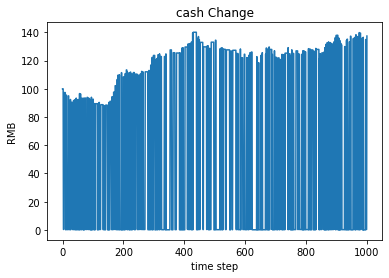

In [149]:
fig, axes = plt.subplots()
axes.plot(range(len(cashList)), cashList)

title = "cash Change"

props = {'title': title,
             'xlabel': 'time step',
             'ylabel': 'RMB',
             }
axes.set(**props)

plt.show()

In [85]:
tmp_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=1, shuffle=False)
cnt = 0
for x, y in tmp_loader:
    cnt+=1
    x,y = x.to(dtype = torch.float), y.to(dtype=torch.int64)
    print(x[0][0][0])
    print(y)
    if cnt==100:
        break


tensor([2.6660e-01, 1.2900e-03, 2.6540e-01, 2.2500e-03, 2.6690e-01, 2.4600e-03,
        2.6530e-01, 1.0330e-02, 2.6700e-01, 5.0000e-04, 2.6510e-01, 2.8900e-03,
        2.6710e-01, 1.4300e-03, 2.6500e-01, 2.0000e-02, 2.6740e-01, 1.8000e-03,
        2.6480e-01, 1.2100e-03, 2.6770e-01, 1.0000e-02, 2.6470e-01, 4.2500e-03,
        2.6810e-01, 2.1000e-04, 2.6460e-01, 2.6300e-03, 2.6880e-01, 5.0000e-03,
        2.6440e-01, 1.6900e-03, 2.6900e-01, 1.2400e-02, 2.6410e-01, 2.8200e-03,
        2.7000e-01, 2.0000e-03, 2.6380e-01, 1.5600e-03])
tensor([0])
tensor([2.6690e-01, 3.9700e-03, 2.6560e-01, 1.4400e-03, 2.6700e-01, 5.0000e-04,
        2.6540e-01, 2.2500e-03, 2.6710e-01, 1.4300e-03, 2.6530e-01, 1.0330e-02,
        2.6770e-01, 1.0000e-02, 2.6510e-01, 7.0200e-03, 2.6810e-01, 2.1000e-04,
        2.6500e-01, 2.0000e-02, 2.6880e-01, 5.0000e-03, 2.6460e-01, 2.6300e-03,
        2.6900e-01, 1.4200e-02, 2.6440e-01, 1.6900e-03, 2.6970e-01, 1.4810e-02,
        2.6410e-01, 2.8200e-03, 2.7000e-01, 2.0000e

In [71]:
# 找寻bid1最大值和ask1最小值
tmp_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=64, shuffle=False)
ask1List = []
bid1List = []
cnt = 0
for x, y in tmp_loader:
    cnt+=1
    x,y = x.to(device, dtype = torch.float), y.to(device, dtype=torch.int64)
    ask1List.append(x[0][0][0][0].item())
    bid1List.append(x[0][0][0][2].item())
    if cnt==300:
        break
print(max(bid1List))
print(min(ask1List))

0.27000001072883606
0.12479999661445618
